In this notebook, we will work with microarray RNA data generated by investigating tumour and normal cancer cells. We will investigate the genes that are differentially expressed in both conditions. Similarly, we will perform some data preprocessing and visualisation steps to preprocess data for analysis and to understand the data, respectively. 

We will load in extracted dataset with their metadata. Preprocessing steps to apply would be to investigate the distribution of the data to determine the presence of outliers. Preliminary exploration to be performed would be to visualise the distribution of the genes expressed in all samples. Due to the large number of genes, we will select a few of them. Similarly, we will decompose these genes into smaller dimensions to determine variations in the data in terms of their principal components (Principal Component Analysis, PCA). Next, we will cluster them to determine the number of clusters that could be obtained. We will use two forms: KMeans and Hierarchical clustering. Furthermore, we will visualise the local and global relationships between genes by using the Uniform Manifold Approximation and Projection (UMAP). We will overlay these with the target classes.

After that, we will find differentially expressed genes. We will use two methods: T-test and linear models since there are two classes. There are more sophisticated methods. The dataset we will be using is one with the GEO accession number `GSE116520`. This data was generated while performing the transcriptome profiling of PDZ Binding Kinase, a novel biomarker, found in the peritumoral brain zone of glioblastoma (cancer). The total RNA from tumour core (TC), Peritumoural brain zone (PT) and non-neoplastic brain tissue (a control) samples were subjected to Illumna bead array. This dataset has been normalised by quantile normalisation and then log2-scaled, hence no transformation will be done.

In [1]:
from pathlib import os
from glob import glob
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal, Union
import plotnine as pn
from sklearn import preprocessing, cluster, metrics
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests # for adjusted pvals
from sklearn.decomposition import PCA

In [2]:
path = os.getcwd()

In [3]:
def read_data(file_id:str, file_type:str, folder:str=None):
    try:
        file = None
        if folder:
            filepath = os.path.join(path, folder)
            file = glob(filepath + f'/{file_id}*{file_type}*.csv')[0]
        else:
            file = glob(path + f'/{file_id}*{file_type}*.csv')[0]
        
        df = pd.read_csv(file, index_col=0)
        return df
    except Exception as err: print(err)

In [4]:
metadata = read_data('GSE116520', 'metadata', 'microarray').reset_index()
gene_counts = read_data('GSE116520', 'counts', 'microarray').T

In [5]:
gene_counts.head()

ID_REF,ILMN_1343291,ILMN_1343295,ILMN_1651199,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651230,ILMN_1651232,...,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311160,ILMN_3311165,ILMN_3311170,ILMN_3311175,ILMN_3311180,ILMN_3311185,ILMN_3311190
GSM3242216,14.032437,12.435607,6.402662,6.666138,6.579272,6.815710,10.966710,8.666884,6.284195,6.592901,...,6.468024,6.406803,6.537197,6.291450,6.716895,6.268282,6.350572,6.377081,6.439392,6.628033
GSM3242217,14.012624,13.379158,6.326161,6.661021,6.360057,6.401387,10.051240,8.908373,6.271326,6.535644,...,6.477359,6.531178,6.712899,6.362179,6.748707,6.383871,6.377871,6.448808,6.568940,6.811224
GSM3242218,13.864100,13.484528,6.372270,6.652996,6.518094,6.480741,12.787245,8.442132,6.391237,6.818070,...,6.589392,6.488869,6.619293,6.476174,6.776191,6.367891,6.393227,6.317557,6.411717,6.602096
GSM3242219,14.059140,13.328843,6.292105,6.633443,6.307037,6.411210,12.437371,10.011964,6.366073,6.549965,...,6.619073,6.570316,6.586012,6.316149,6.803801,6.416242,6.289540,6.582053,6.418153,6.785057
GSM3242220,13.797549,13.282239,6.357153,6.826525,6.564816,6.377278,12.727407,9.363087,6.471363,6.646395,...,6.760732,6.418721,6.499872,6.303477,7.011902,6.327228,6.481871,6.418349,6.430580,6.600433


In [6]:
metadata.head()

,disease state,grade,tissue,gender,age,class,sample_id
0,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242216
1,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242217
2,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242218
3,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242219
4,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242220


In [7]:
def get_outliers(x:pd.DataFrame, method:Literal['zscore', 'iqr']='zscore'):
    try:
        if method == 'zscore':
            x_mean = x.mean()
            x_std = x.std()
            x_scaled = (x - x_mean)/x_std
            n_outliers = np.sum(abs(x_scaled) > 3, axis=0)
            return n_outliers
        elif method == 'iqr':
            p25 = x.quantile(q=0.25)
            p75 = x.quantile(q=0.75)
            iqr = p75 - p25
            lower = p25 - 1.5*iqr
            upper = p75 + 1.5*iqr
            n_outliers = np.sum((x < lower) | (x > upper), axis=0)
            return n_outliers
    except Exception as err: print(err)

In [8]:
def describe_data(x):
    res = pd.DataFrame(columns=x.columns)
    res.loc['std', :] = x.std()
    res.loc['mean', :] = x.mean()
    res.loc['min', :] = x.min()
    res.loc['p25', :] = x.quantile(q=0.25)
    res.loc['median', :] = x.median()
    res.loc['p75', :] = x.quantile(q=0.75)
    res.loc['max', :] = x.median()
    res.loc['skew', :] = x.skew()
    res.loc['kurt', :] = x.kurtosis()
    res.loc['iqr', :] = x.quantile(q=0.75) - x.quantile(q=0.25)
    res.loc['num_outliers'] = get_outliers(x)
    return res

In [9]:
describe_data(gene_counts)

ID_REF,ILMN_1343291,ILMN_1343295,ILMN_1651199,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651230,ILMN_1651232,...,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311160,ILMN_3311165,ILMN_3311170,ILMN_3311175,ILMN_3311180,ILMN_3311185,ILMN_3311190
std,0.125957,0.589562,0.080604,0.145373,0.09926,0.097761,1.144026,0.688103,0.075226,0.177273,...,0.120861,0.128312,0.073656,0.095072,0.166276,0.064201,0.072966,0.087624,0.072122,0.117453
mean,13.926293,12.418963,6.333701,6.690445,6.404587,6.478372,11.860025,9.306087,6.358787,6.638635,...,6.576072,6.396261,6.591913,6.374951,6.728698,6.369746,6.405246,6.449572,6.408854,6.691111
min,13.501263,11.335841,6.148102,6.497278,6.232493,6.318572,9.499166,7.905329,6.174246,6.320079,...,6.31735,6.158887,6.454757,6.223618,6.442508,6.250605,6.261609,6.305062,6.240016,6.448094
p25,13.860314,12.000518,6.292225,6.58648,6.331993,6.411592,10.800566,8.807137,6.30319,6.547422,...,6.486259,6.321929,6.536916,6.302833,6.60658,6.328545,6.352323,6.396597,6.3594,6.613151
median,13.961921,12.505506,6.326258,6.665291,6.39394,6.478132,12.475758,9.277022,6.367537,6.614565,...,6.572406,6.383431,6.587473,6.366555,6.717755,6.370514,6.408238,6.440343,6.42092,6.684307
p75,14.02324,12.781224,6.370507,6.755094,6.450305,6.534021,12.595113,9.932507,6.403193,6.696191,...,6.653655,6.444543,6.632121,6.428926,6.807015,6.420117,6.440946,6.499538,6.444807,6.748071
max,13.961921,12.505506,6.326258,6.665291,6.39394,6.478132,12.475758,9.277022,6.367537,6.614565,...,6.572406,6.383431,6.587473,6.366555,6.717755,6.370514,6.408238,6.440343,6.42092,6.684307
skew,-1.19919,-0.115896,0.707718,1.301324,0.574906,0.939734,-1.043338,0.052102,-0.076805,1.414092,...,0.221742,1.494927,0.153865,0.779587,0.573456,-0.105354,0.68335,0.645494,0.074421,0.25376
kurt,2.105957,-0.793267,1.864839,2.285713,-0.439367,2.143543,-0.712402,-0.592191,0.037035,3.860046,...,-0.354566,4.93884,-0.714317,0.738076,-0.312222,-0.681512,1.095257,0.268118,0.330502,0.129315
iqr,0.162927,0.780707,0.078282,0.168614,0.118312,0.122429,1.794548,1.12537,0.100003,0.148769,...,0.167396,0.122614,0.095205,0.126093,0.200435,0.091572,0.088623,0.102941,0.085407,0.134919


In [10]:
def plot_distribution(df, num_genes=15, ncol=5, nrow=3, seed=None, figsize=(12,6), plot_type='kde'):
    """
    Plots the distribution of randomly selected genes against the class
    :param df: Pandas dataframe
    :param num_genes: Number of genes to plot distribution
    :param seed: Random seed value
    """
    try:
        if seed:
            rnd = np.random.RandomState(seed)
            random_idx = rnd.choice(range(len(df)), num_genes, replace=False)
        else:
            random_idx = np.random.choice(range(len(df)), num_genes, replace=False)

        selected_cols = df.columns[random_idx]

        # visualise
        plt.rcParams['font.size'] = 8
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        axes = axes.flatten()
        for col, ax in zip(selected_cols, axes):
            if plot_type == 'box':
                sns.boxplot(data=df, x=metadata['class'].values, y=col, hue=metadata['class'].values, ax=ax, width=0.6)
            elif plot_type == 'kde':
                sns.kdeplot(data=df, x=col, hue=metadata['class'].values, ax=ax)
            ax.set(xlabel='', ylabel='')
            ax.set_title(f"Gene: {col.replace('_', ' ')}", loc='left', fontsize=9, fontweight='bold')
        fig.tight_layout()
        plt.rcdefaults()
        plt.show()
    except Exception as err: print(err)

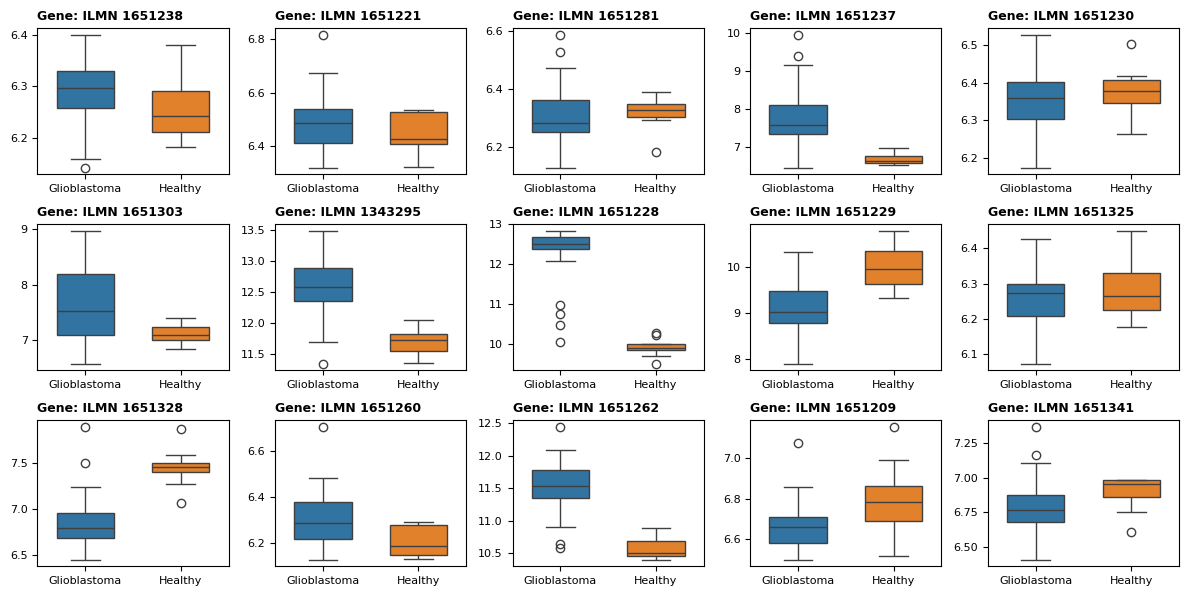

In [11]:
plot_distribution(gene_counts, plot_type='box')

- By visualising some of the genes by cancerous and healthy tissues, we can clearly see that there are some genes that are differentiated during healthy and diseased state
- Also, we see the presence of outliers in some of the groups.
- Quantile transformation involves normalising gene samples such that the distribution of gene expression values is the same across all samples. Another method is the Robust Multi-Array Average (RMA) which performs background correction of array signals, normalisation and summarisation based on median values

__Dimensionality Reduction and Visualisation__

Here, we will decompose the genes into smaller components (2) and visualise them in 2D-projection. We will use the PCA technique which decomposes gene data into principal components which are directions in the feature space that capture the largest variance. Next, we will apply UMAP method.

In [12]:
def reduce_dimensions(df, n_components=2, reduction_type:Literal['pca', 'umaps']='pca', 
                      figsize=(8,5), labels=None, plot=True):
    try:
        X_scaled = preprocessing.StandardScaler().fit_transform(df.values)
        if reduction_type == 'pca':
            reducer = PCA(n_components=n_components, random_state=42)
            X_trans = reducer.fit_transform(X_scaled)
        elif reduction_type == 'umaps':
            reducer = umap.UMAP(n_components=n_components, random_state=42, n_jobs=1)
            X_trans = reducer.fit_transform(X_scaled)

        if plot:
            # visualise
            X_trans = pd.DataFrame(X_trans[:, :2], columns=['Component1', 'Component2'])
            if labels is not None:
                labels = list(map(lambda x: f'cluster {x+1}', labels))
                X_trans['target'] = labels
            else:
                X_trans['target'] = metadata['class']
            fig = (
                pn.ggplot(data=X_trans, mapping=pn.aes('Component1', 'Component2', color='target')) +
                pn.geom_point(size=2) +
                pn.theme_bw() +
                pn.theme(plot_title=pn.element_text(face='bold', hjust=0, size=12), 
                        legend_position = 'inside', 
                        figure_size = figsize,
                        legend_key = pn.element_blank(),
                        legend_title = pn.element_text(hjust=0.5, face='bold'),
                        panel_grid = pn.element_blank(),
                        legend_position_inside=(0.01, 0.96)
                        ) +
                pn.labs(title=f"{reduction_type.replace('s', '').upper()} Dimensionality Reduction", color='Class') +
                pn.scale_x_continuous(expand=(0.1, 0.15, 0.15, 0.1)) +
                pn.scale_y_continuous(expand=(0.1, 0.1, 0.1, 0.1)) +
                pn.scale_color_manual(values=('coral', 'steelblue'))
            )

            fig.show()
        else:
            return pd.DataFrame(X_trans, columns=[f'PC{i+1}' for i in range(X_trans.shape[1])])
    except TypeError as err: print(err)

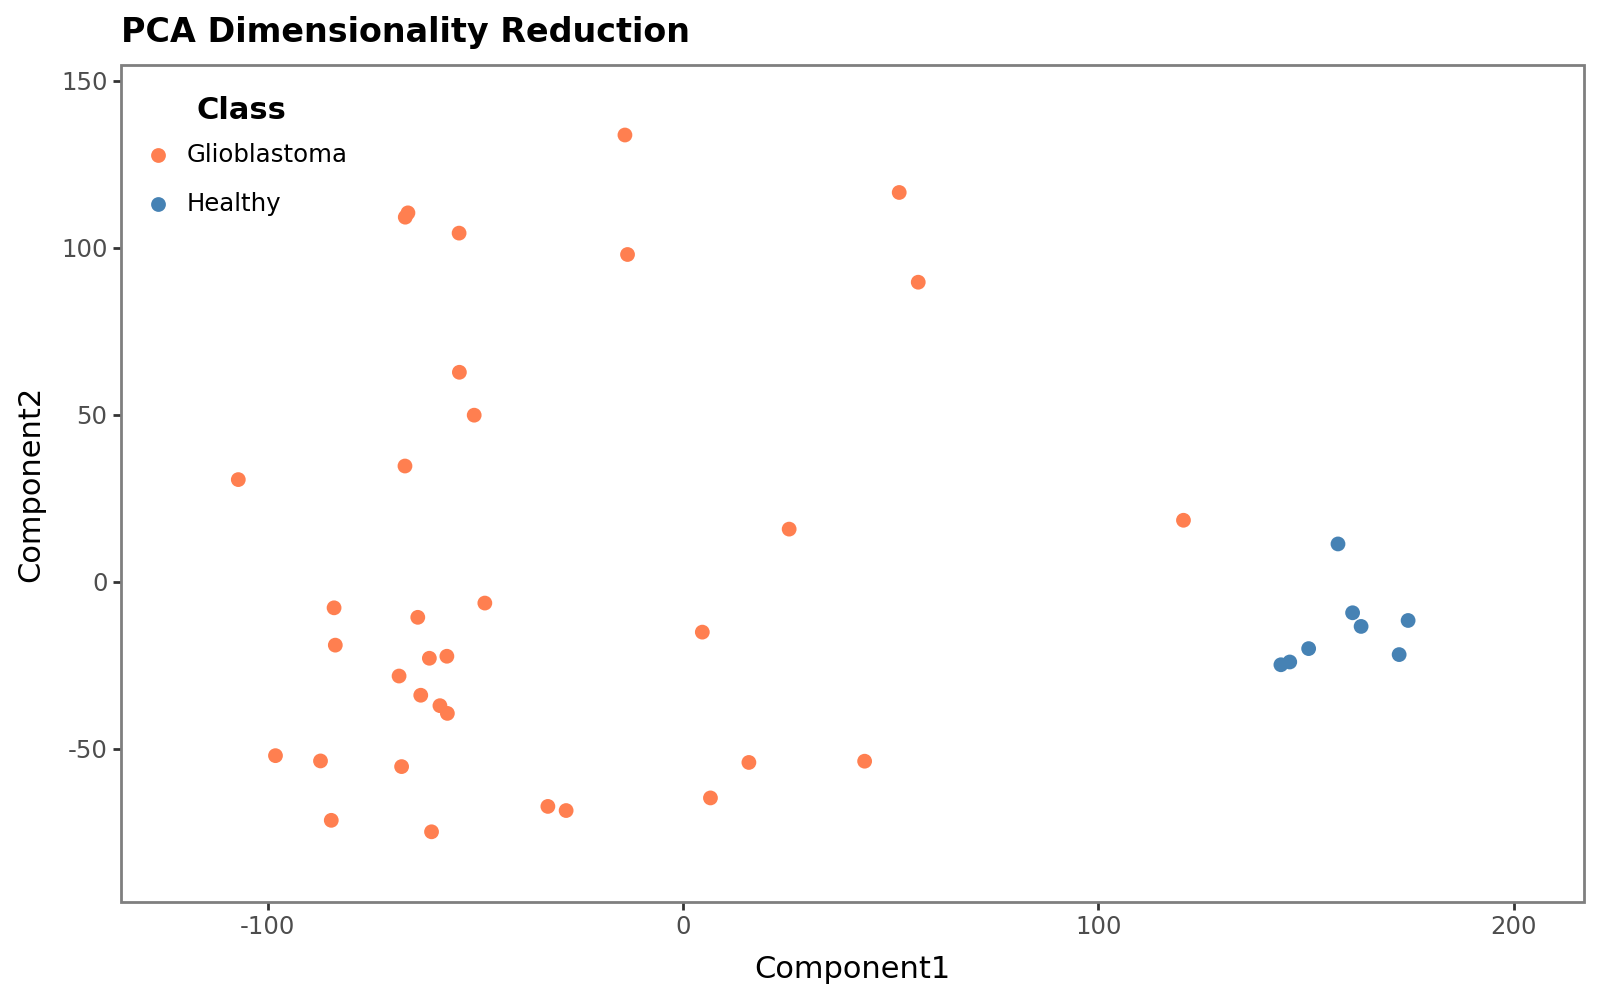

In [13]:
reduce_dimensions(gene_counts, reduction_type='pca')

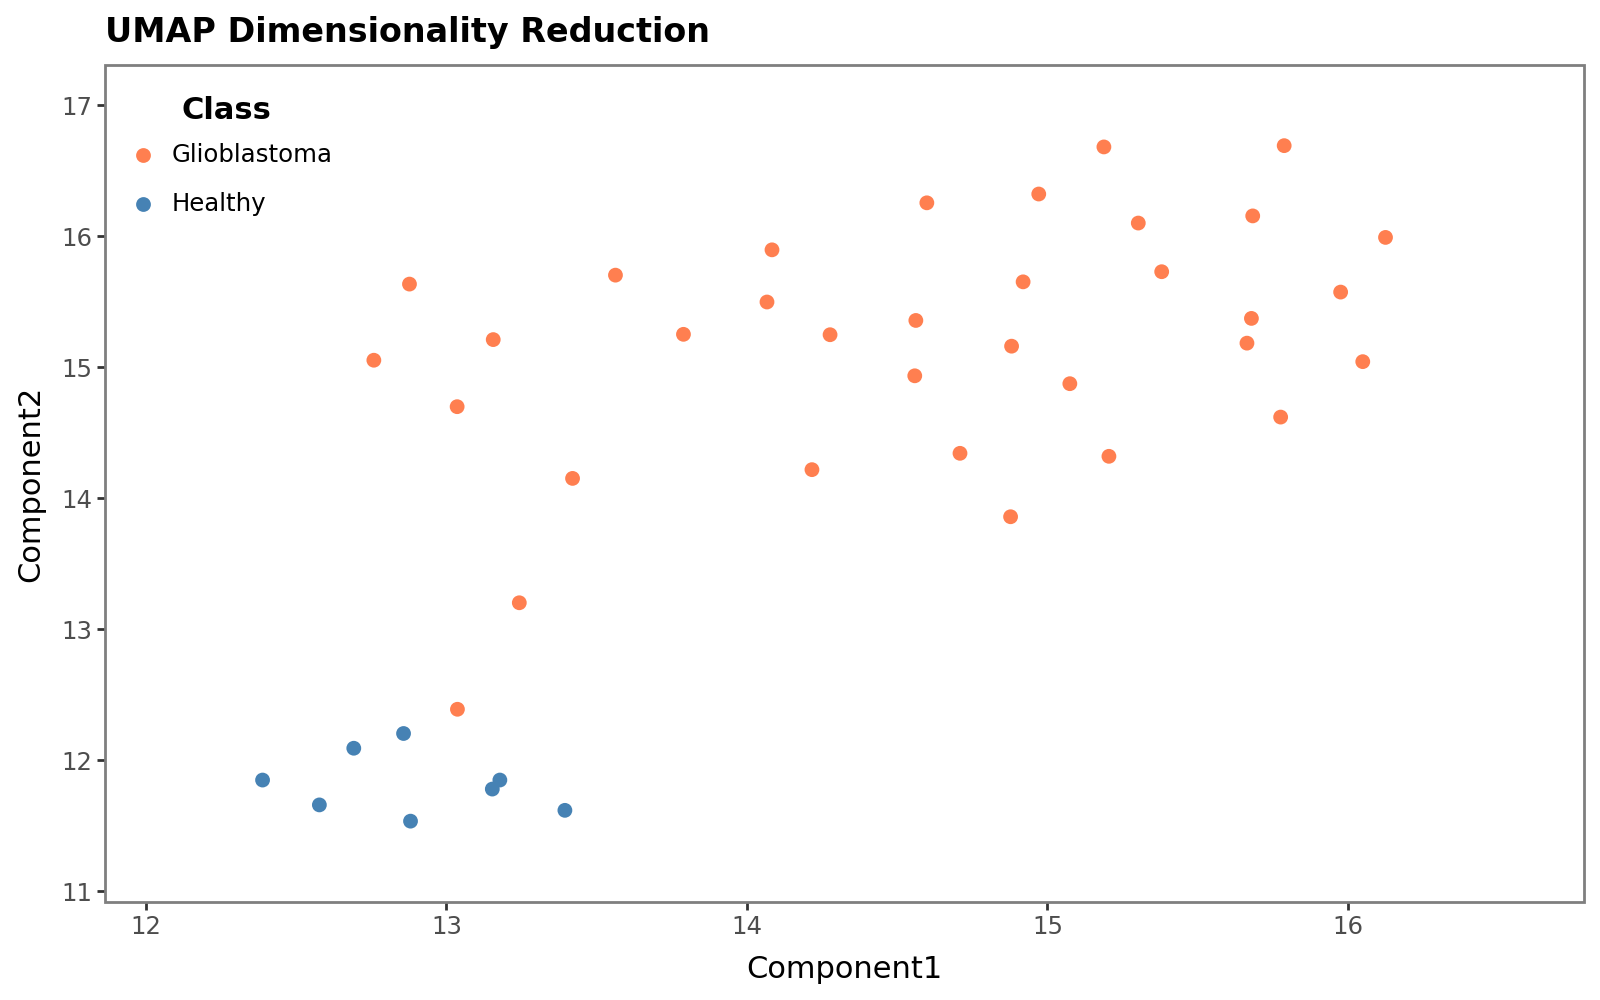

In [14]:
reduce_dimensions(gene_counts, reduction_type='umaps')

- From above visualisation (PCA and UMAP), we can see that both healthy and cancerous tissues can be differentiated.
- In UMAP, the healthy samples cluster at the lower left side of the components, while the diseased cluster around the middle zone.
- In PCA, the healthy samples cluster at the lower right of the components while the diseased samples around the other directions in the 2D-space
- Similarly, in both methods, one diseased sample lies closer to the normal brain tissue samples. This may indicate the degree of cancer state.

Next, we will cluster these genes and determine the optimal number of clusters. We will use the KMeans clustering method.

In [15]:
def run_optimal_clusters(df, n_clusters=20,scale=True, decompose=False, 
                         variance_cutoff:Union[int,float]=0.95, 
                         dist_type:Literal['cosine', 'euclidean', 'correlation']='cosine'):
    n_clusters = n_clusters
    sil_scores = []
    # reduce number of dimensions
    X = df.copy()

    if decompose:
        X = reduce_dimensions(df, n_components=variance_cutoff, plot=False)
        print('Number of components capturing {:.0f}% variance is {}'.format(100*variance_cutoff, X.shape[1]))
    if scale:
        X = preprocessing.StandardScaler().fit_transform(X)
    

    for i in range(2, n_clusters+1):
        if dist_type == 'euclidean':
            res = cluster.AgglomerativeClustering(i, linkage='ward', metric=dist_type)
        else:
            res = cluster.AgglomerativeClustering(i, linkage='average', metric=dist_type)
        res.fit(X)
        sil_scores.append(metrics.silhouette_score(X, res.labels_))

    # visualise
    fig, ax = plt.subplots(1, figsize=(8,4.5))
    ax.plot(list(range(2,n_clusters+1)), sil_scores, 'o-', linewidth=1.4, markersize=3)
    ax.set_xticks(range(2, n_clusters+1, 2), range(2, n_clusters+1, 2))
    ax.set_xlabel('Number of clusters')
    ax.set_title('Silhouette Method', loc='left', fontweight='bold', fontsize=10)
    ax.set_ylabel('Silhouette scores', fontweight='bold')
    fig.tight_layout()
    plt.show()

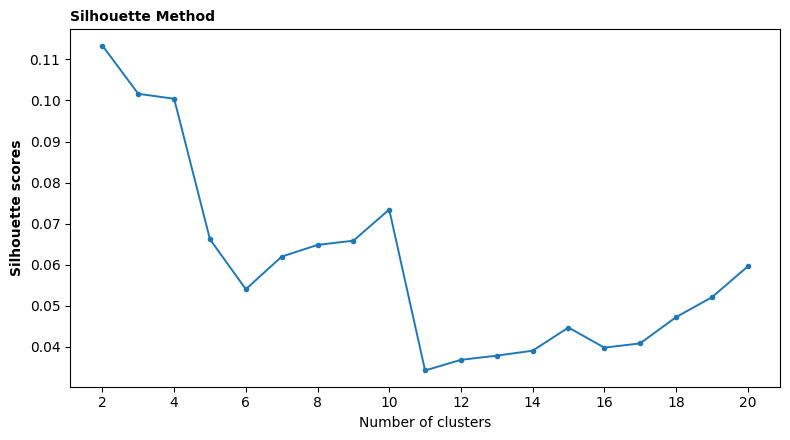

In [16]:
run_optimal_clusters(gene_counts, scale=True, dist_type='correlation')

Number of components capturing 95% variance is 36


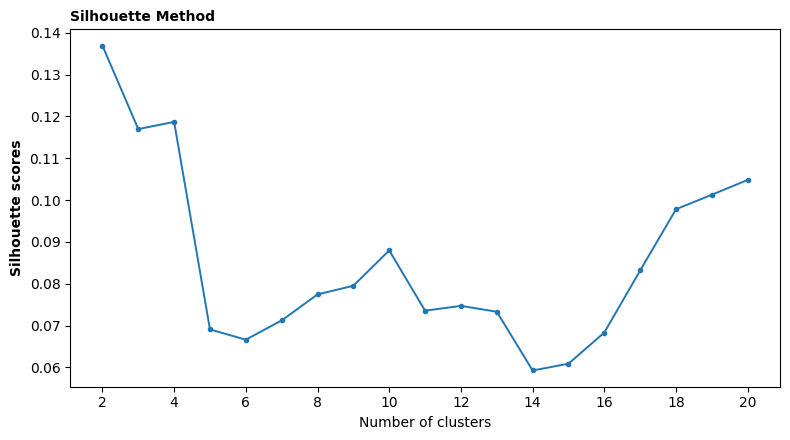

In [17]:
run_optimal_clusters(gene_counts, decompose=True, scale=False)

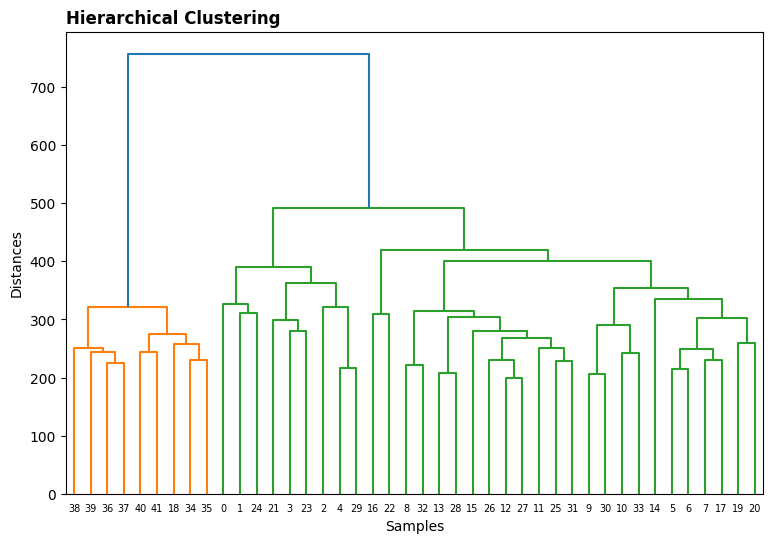

In [18]:
plt.figure(figsize=(9,6))
dendrogram(linkage(preprocessing.StandardScaler().fit_transform(gene_counts), method='ward', metric='euclidean'))
plt.title('Hierarchical Clustering', loc='left', fontweight='bold')
plt.ylabel('Distances')
plt.xlabel('Samples')
plt.xticks(rotation=0, fontsize=7)
plt.show()

- By using the silhouette method to determine the optimal number of clusters, two clusters had higher silhouette scores.
- Similarly from hierarchical clustering, two clusters were obtained when the distance is cut at about 500 (using the ward linkage and euclidean distance metric)
- We will therefore cluster the data into two groups

In [19]:
def cluster_genes(
        df:pd.DataFrame, 
        n_clusters:int=2,
        decompose:bool=False,
        variance_cutoff:Union[int,float]=0.95,
        scale:bool=False):
    """
    Clusters genes using Hierarchical Agglomerative clustering. 

    :param df: Pandas DataFrame
    :param n_cluster: Number of clusters
    :param decompose: Apply PCA to decompose features into Principal components
    :param variance_cutoff: Percentage variance captured by principal components (PCs)
    :param scale: To scale data (Standardisation)
    """
    X = df.copy()
    
    # reduce dimensions
    if decompose:
        X = reduce_dimensions(df, n_components=variance_cutoff, plot=False)
        print('Number of components capturing {:.0f}% variance is {}'.format(100*variance_cutoff, X.shape[1]))
    if scale:
        X = preprocessing.StandardScaler().fit_transform(X)

    # fit cluster
    res = cluster.AgglomerativeClustering(n_clusters, metric='euclidean', linkage='ward')    
    res.fit(X)
    labels = res.labels_
    
    # visualise data using pca
    reduce_dimensions(df, labels=labels, plot=True)

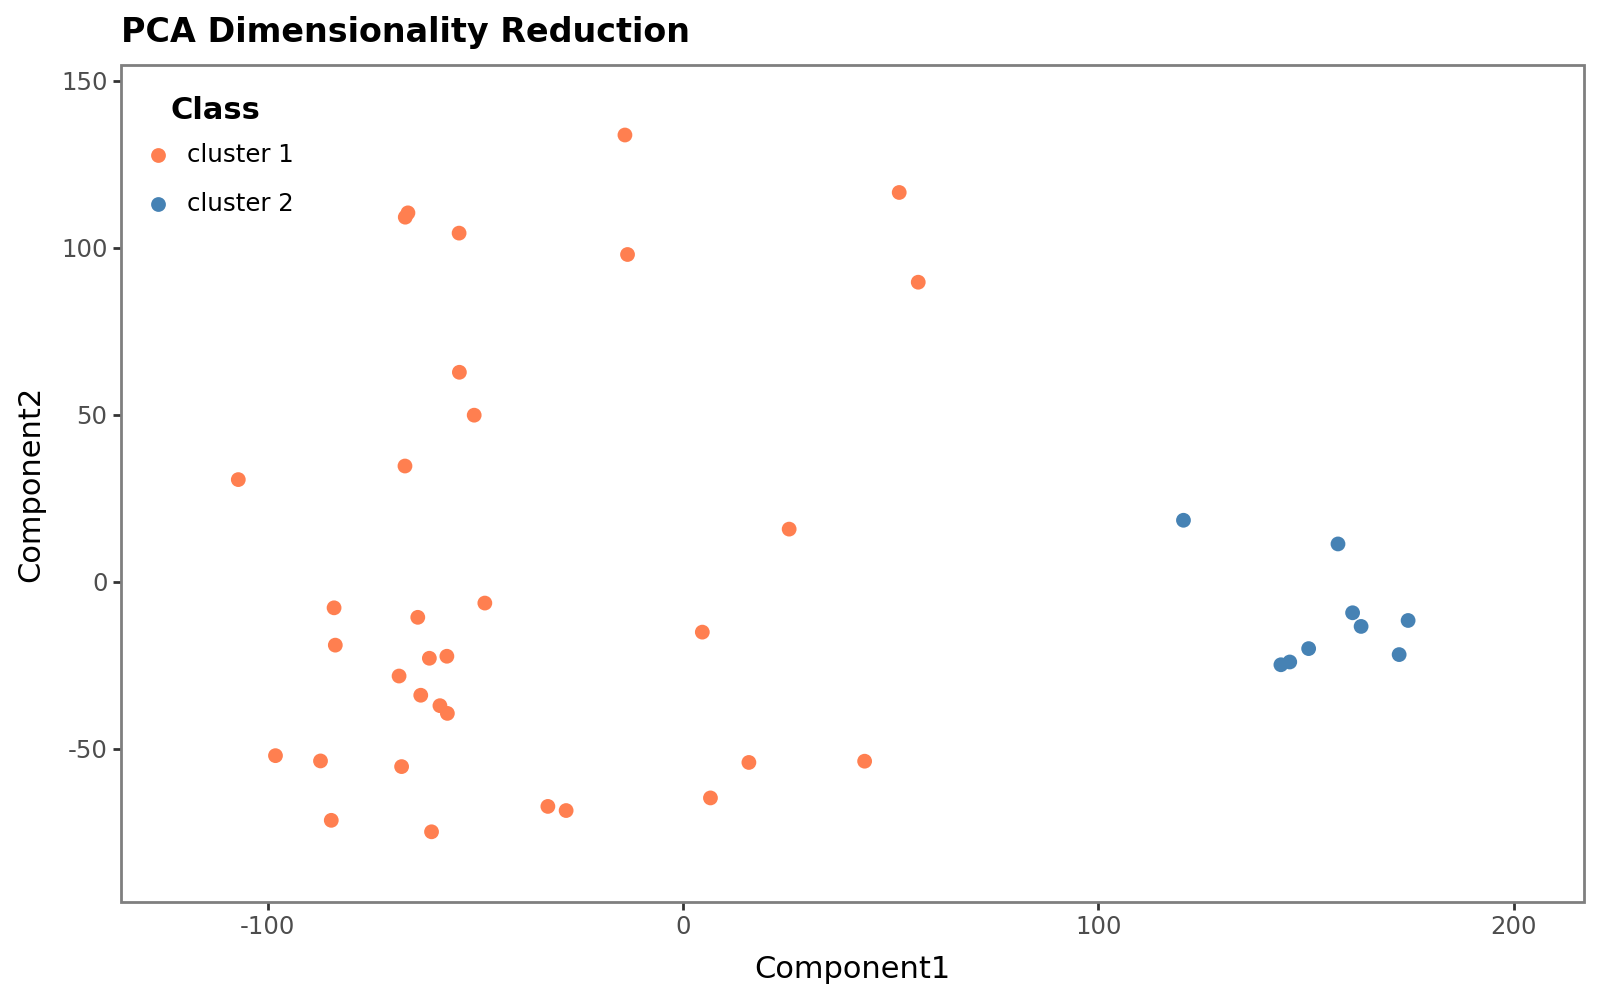

In [20]:
cluster_genes(gene_counts, scale=True)

__Differential Gene Analysis__

Here, we will perform differential gene expression to determine which genes are upregulated in cancer (glioblastoma). We will use two methods, the T-test statistical test and linear regression model.

In [39]:
def get_groups(genes, targets):
    groups_dict = {}
    unique_targets = np.unique(targets)
    for i in unique_targets:
        groups_dict[f'{i.lower()}'] = genes.values[targets == i]
    return groups_dict

In [361]:
def run_stat_test(genes, targets, pos_label=None):
    subtract = np.vectorize(lambda x,y: x - y) # calculates log2 fold change
    # get group datasets
    gene_names = genes.columns.tolist()
    grouped_data = get_groups(genes, targets)
    groups = list(grouped_data.keys()) # get target class names

    # get their respective mean values
    grouped_mean_vals = np.column_stack(list(map(lambda x: np.mean(x, axis=0), grouped_data.values())))
    grouped_mean_vals = pd.DataFrame(grouped_mean_vals, columns=groups)

    if pos_label:
        # sort based on user's target class of interest
        groups = [pos_label] + [i for i in groups if i != pos_label]
    
    # reverse by positive label (label of interest)
    grouped_mean_vals = grouped_mean_vals[groups]
    grouped_mean_vals = [grouped_mean_vals.iloc[:, i] for i in range(grouped_mean_vals.shape[1])]
    
    # get log2FC
    LFC = subtract(*grouped_mean_vals)

    # perform stat test
    if len(grouped_data.keys()) == 2:
        stat, pval = stats.ttest_ind(*grouped_data.values())
        _, adj_pval, _, _ = multipletests(pval, method='fdr_bh')
    else:
        print('Number of groups must be 2')
        exit()
    result = pd.DataFrame(np.c_[LFC, stat, pval, adj_pval], index=gene_names, columns=['Log2FC', 'stat', 'pval', 'p_adj'])
    return result

In [362]:
def DGE_analysis(genes, target, pos_label=None, method='ttest'):
    if method == 'ttest':
        result = run_stat_test(genes, target, pos_label)
        return result

In [363]:
results = DGE_analysis(gene_counts, metadata['class'], pos_label='glioblastoma')

In [366]:
upregulated_genes = results[(results.p_adj < 0.05) & (results.Log2FC > 2)]
downregulated_genes = results[(results.p_adj < 0.05) & (results.Log2FC < -2)]

In [367]:
upregulated_genes.shape, downregulated_genes.shape

((211, 4), (381, 4))